In [1]:
# 🚀 TEMPORAL GRAPH COLORING WITH GNNs - COMPLETE CORRECTED IMPLEMENTATION
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

/Users/atharvamendhulkar/Desktop/GNN/gnn-env/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/atharvamendhulkar/Desktop/GNN/gnn-env/lib/python3.12/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.12/Python
  Referenced from: <441E30E4-F1D4-325A-924A-8C4E5BD0FA29> /Users/atharvamendhulkar/Desktop/GNN/gnn-env/lib/python3.12/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/Users/atharvamendhulkar/Desktop/GNN/gnn-env/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred whi

In [2]:
# %%
print("🚀 Temporal Graph Coloring with GNNs - Fresh Implementation")
print("=" * 60)

🚀 Temporal Graph Coloring with GNNs - Fresh Implementation


In [3]:
# 🔧 REPRODUCIBILITY SETUP
def set_all_seeds(seed: int = 42) -> None:
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
    print(f"✅ All random seeds set to {seed}")

set_all_seeds(42)

✅ All random seeds set to 42


In [4]:
# 📊 CORE METRICS & HELPERS
def count_conflicts(colors: torch.Tensor, edge_index: torch.Tensor) -> int:
    if edge_index.size(1) == 0: return 0
    src, dst = edge_index
    return (colors[src] == colors[dst]).sum().item()

def count_recolors(prev_colors: Optional[torch.Tensor], curr_colors: torch.Tensor) -> int:
    if prev_colors is None: return 0
    return (prev_colors != curr_colors).sum().item()

def count_colors_used(colors: torch.Tensor) -> int:
    return len(torch.unique(colors))

def compute_all_metrics(prev_colors, curr_colors, edge_index) -> Dict[str, float]:
    return {
        'conflicts': count_conflicts(curr_colors, edge_index),
        'recolors': count_recolors(prev_colors, curr_colors),
        'colors_used': count_colors_used(curr_colors)
    }

def compute_avg_metrics(color_sequences: List[torch.Tensor], graphs: List) -> Dict[str, float]:
    conflicts, recolors, prev = [], [], None
    for colors, g in zip(color_sequences, graphs):
        conflicts.append(count_conflicts(colors, g.edge_index))
        recolors.append(count_recolors(prev, colors))
        prev = colors
    return {'avg_conflicts': float(np.mean(conflicts)), 'avg_recolors': float(np.mean(recolors))}

print("✅ Core metrics functions implemented")


✅ Core metrics functions implemented


In [5]:
# 🏗️ TEMPORAL GNN
class TemporalGraphColoringGNN(nn.Module):
    def __init__(self, num_colors: int, hidden_dim: int = 64, num_layers: int = 2):
        super().__init__()
        self.num_colors, self.hidden_dim = num_colors, hidden_dim
        input_dim = 1 + num_colors
        self.gcn_layers = nn.ModuleList([
            GCNConv(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)
        ])
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, num_colors)
        self.hidden_state = None

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        h = x
        for i, gcn in enumerate(self.gcn_layers):
            h = gcn(h, edge_index)
            if i < len(self.gcn_layers) - 1: h = F.relu(h)
        h = h.unsqueeze(1)
        if self.hidden_state is None:
            self.hidden_state = torch.zeros(1, h.size(0), self.hidden_dim, device=h.device, dtype=h.dtype)
        h, self.hidden_state = self.gru(h, self.hidden_state)
        return self.output(h.squeeze(1))

    def reset_temporal_state(self):
        self.hidden_state = None

print("✅ Temporal GNN implemented")

# %%

✅ Temporal GNN implemented


In [6]:
# 🎯 LOSS & REPAIR
def temporal_coloring_loss(logits, edge_index, prev_colors=None, lambda_conflict=1.0, lambda_recolor=0.5):
    probs = F.softmax(logits, dim=1)
    preds = logits.argmax(dim=1)
    conflict_loss = 0.0
    if edge_index.size(1) > 0:
        src, dst = edge_index
        conflict_loss = (probs[src] * probs[dst]).sum(dim=1).mean()
    recolor_loss = 0.0
    if prev_colors is not None:
        prev_prob = probs[torch.arange(len(prev_colors)), prev_colors]
        recolor_loss = (1 - prev_prob).mean()
    return lambda_conflict * conflict_loss + lambda_recolor * recolor_loss, preds

def get_node_neighbors(node: int, edge_index: torch.Tensor) -> List[int]:
    src, dst = edge_index
    return list(set(dst[src == node].tolist() + src[dst == node].tolist()))

def local_greedy_repair(colors, edge_index, num_colors, max_repairs=5, verbose=False):
    if edge_index.size(1) == 0: return colors, 0
    src, dst = edge_index
    conflicts = (colors[src] == colors[dst])
    if conflicts.sum() == 0: return colors, 0
    
    nodes = torch.cat([src[conflicts], dst[conflicts]])
    counts = {}
    for n in nodes.tolist(): counts[n] = counts.get(n, 0) + 1
    sorted_nodes = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    repaired, repairs = colors.clone(), 0
    for n, _ in sorted_nodes[:max_repairs]:
        neigh = get_node_neighbors(n, edge_index)
        used = repaired[neigh]
        for c in range(num_colors):
            if c not in used and repaired[n] != c:
                repaired[n] = c; repairs += 1; break
    return repaired, repairs

def probabilistic_repair(colors, edge_index, num_colors, repair_probability=0.3, max_repairs=5, verbose=False):
    if random.random() > repair_probability: return colors, 0
    return local_greedy_repair(colors, edge_index, num_colors, max_repairs, verbose)

print("✅ Loss & repair functions implemented")

✅ Loss & repair functions implemented


In [7]:
# 🎲 GRAPH GENERATION
def generate_temporal_graph_sequence(num_nodes=100, initial_edges=200, num_snapshots=10,
                                     graph_type="ER", change_rate=0.1, seed_offset=0):
    seq_seed = 42 + seed_offset
    random.seed(seq_seed); np.random.seed(seq_seed)
    
    if graph_type == "ER":
        G = nx.gnm_random_graph(num_nodes, initial_edges, seed=seq_seed)
    elif graph_type == "BA":
        G = nx.barabasi_albert_graph(num_nodes, max(1, initial_edges//num_nodes), seed=seq_seed)
    else:
        k = min(6, max(2,(initial_edges*2)//num_nodes))
        if k%2: k+=1
        G = nx.watts_strogatz_graph(num_nodes, k, 0.1, seed=seq_seed)
    
    while G.number_of_edges() < initial_edges:
        u,v = random.sample(range(num_nodes),2)
        G.add_edge(u,v)
    
    graphs = [G.copy()]
    for _ in range(1, num_snapshots):
        changes = max(1, int(G.number_of_edges() * change_rate))
        for _ in range(changes):
            if random.random()<0.5 and G.number_of_edges()>num_nodes//2:
                G.remove_edge(*random.choice(list(G.edges())))
            else:
                for _ in range(10):
                    u,v = random.sample(range(num_nodes),2)
                    if not G.has_edge(u,v): G.add_edge(u,v); break
        graphs.append(G.copy())
    return graphs

def convert_to_pyg(graphs): return [from_networkx(G) for G in graphs]

print("✅ Graph generation implemented")


✅ Graph generation implemented


In [8]:
# 🔧 CLASSICAL BASELINES
def incremental_greedy_coloring(graphs: List, num_colors: int = 6):
    prev_colors, seq = None, []
    for g in graphs:
        n, ei = g.num_nodes, g.edge_index
        colors = torch.full((n,), -1, dtype=torch.long)
        if prev_colors is not None: colors = prev_colors.clone()
        
        for u in range(n):
            neigh = get_node_neighbors(u, ei)
            if colors[u] == -1 or colors[u] in colors[neigh]:
                for c in range(num_colors):
                    if c not in colors[neigh]:
                        colors[u] = c; break
        seq.append(colors); prev_colors = colors
    return seq

def incremental_dsatur_coloring(graphs: List, num_colors: int = 6):
    prev_colors, seq = None, []
    for g in graphs:
        n, ei = g.num_nodes, g.edge_index
        colors = torch.full((n,), -1, dtype=torch.long)
        if prev_colors is not None: colors = prev_colors.clone()
        
        uncolored = set(range(n))
        while uncolored:
            sat = {}
            for u in uncolored:
                neigh = get_node_neighbors(u, ei)
                sat[u] = len(set(colors[neigh].tolist()) - {-1})
            max_sat = max(sat.values())
            cands = [u for u,d in sat.items() if d==max_sat]
            degs = {u: len(get_node_neighbors(u,ei)) for u in cands}
            max_deg = max(degs.values())
            cands = [u for u in cands if degs[u]==max_deg]
            u = min(cands)
            
            neigh = get_node_neighbors(u, ei)
            used = set(colors[neigh].tolist())
            for c in range(num_colors):
                if c not in used: colors[u] = c; break
            uncolored.remove(u)
        seq.append(colors); prev_colors = colors
    return seq

def classical_with_limited_repair(graphs, base_method: str, num_colors=6, max_repairs=5):
    orig = incremental_greedy_coloring(graphs, num_colors) if base_method=="greedy" else incremental_dsatur_coloring(graphs, num_colors)
    repaired = []
    for colors,g in zip(orig,graphs):
        fixed,_ = local_greedy_repair(colors, g.edge_index, num_colors, max_repairs, verbose=False)
        repaired.append(fixed)
    return orig, repaired

print("✅ Classical baselines implemented")

✅ Classical baselines implemented


In [9]:
# 🔬 EXPERIMENT ENGINE
class TemporalColoringExperiment:
    def __init__(self, num_colors=6, device='cpu'):
        self.num_colors, self.device = num_colors, device

    def prepare_features(self, graph, prev_colors):
        n = graph.num_nodes
        deg = torch.zeros(n, device=self.device)
        if graph.edge_index.size(1)>0:
            deg.scatter_add_(0, graph.edge_index[0], torch.ones(graph.edge_index.size(1), device=self.device))
        deg = deg.unsqueeze(1)
        
        if prev_colors is not None:
            prev_feat = F.one_hot(prev_colors, num_classes=self.num_colors).float()
        else:
            prev_feat = torch.zeros(n, self.num_colors, device=self.device)
        return torch.cat([deg, prev_feat], dim=1)

    def run_experiment(self, graphs, method="pure_gnn", max_repairs=5, repair_probability=0.3, verbose=True):
        model = TemporalGraphColoringGNN(self.num_colors).to(self.device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        res = {k:[] for k in ['gnn_conflicts','gnn_recolors','final_conflicts','final_recolors','repairs_made','latency']}
        model.reset_temporal_state(); prev = None
        
        for t,g in enumerate(graphs):
            start = time.time()
            g = g.to(self.device)
            feat = self.prepare_features(g, prev)
            
            opt.zero_grad()
            logit = model(feat, g.edge_index)
            loss, preds = temporal_coloring_loss(logit, g.edge_index, prev)
            loss.backward(); opt.step()
            
            c1, r1 = count_conflicts(preds, g.edge_index), count_recolors(prev, preds)
            if method=="pure_gnn":
                final, rep = preds, 0
            elif method=="limited_repair":
                final, rep = local_greedy_repair(preds, g.edge_index, self.num_colors, max_repairs)
            else:
                final, rep = probabilistic_repair(preds, g.edge_index, self.num_colors, repair_probability, max_repairs)
            
            c2, r2 = count_conflicts(final, g.edge_index), count_recolors(prev, final)
            res['gnn_conflicts'].append(c1); res['gnn_recolors'].append(r1)
            res['final_conflicts'].append(c2); res['final_recolors'].append(r2)
            res['repairs_made'].append(rep); res['latency'].append(time.time()-start)
            prev = final
            if hasattr(model,'hidden_state'): model.hidden_state = model.hidden_state.detach()
        return res

print("✅ Experiment engine implemented")

✅ Experiment engine implemented


In [10]:
# 📊 ANALYSIS FUNCTIONS
def analyze_experiment_results(results: Dict, method_name: str = "Experiment"):
    if not results['final_conflicts']: return
    
    print(f"\n📊 {method_name.upper()} ANALYSIS")
    print("=" * 60)
    
    avg_gnn_conf = np.mean(results['gnn_conflicts'])
    avg_gnn_rec = np.mean(results['gnn_recolors'])
    avg_final_conf = np.mean(results['final_conflicts'])
    avg_final_rec = np.mean(results['final_recolors'])
    avg_repairs = np.mean(results['repairs_made'])
    avg_lat = np.mean(results['latency']) * 1000
    
    print(f"🧠 RAW GNN: Conflicts={avg_gnn_conf:.1f}, Recolors={avg_gnn_rec:.1f}")
    print(f"🔧 REPAIR: Avg repairs={avg_repairs:.1f}, Total={sum(results['repairs_made'])}")
    print(f"🏆 FINAL: Conflicts={avg_final_conf:.1f}, Recolors={avg_final_rec:.1f}, Latency={avg_lat:.1f}ms")
    
    if avg_gnn_conf > 0:
        reduction = ((avg_gnn_conf - avg_final_conf) / avg_gnn_conf) * 100
        print(f"📈 REPAIR EFFECTIVENESS: {reduction:.1f}% conflict reduction")

def compare_methods(results_dict: Dict[str, Dict], graph_size: int):
    print(f"\n⚖️ METHOD COMPARISON - {graph_size} NODES")
    print("="*70)
    print(f"{'Method':<20} {'Conflicts':<10} {'Repairs':<8} {'Recolors':<10}")
    print("-"*70)
    
    for name, res in results_dict.items():
        if 'avg_conflicts' in res:
            conf, recol, repairs = res['avg_conflicts'], res.get('avg_recolors',0), res.get('avg_repairs',0)
        else:
            conf = float(np.mean(res['final_conflicts']))
            recol = float(np.mean(res['final_recolors']))
            repairs = float(np.mean(res['repairs_made']))
        print(f"{name:<20} {conf:<10.1f} {repairs:<8.1f} {recol:<10.1f}")

def plot_learning_curves(results_dict: Dict[str, Dict], title: str = "Learning Curves"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    for name, res in results_dict.items():
        if 'gnn_conflicts' in res and len(res['gnn_conflicts']) > 1:
            t = range(len(res['gnn_conflicts']))
            ax1.plot(t, res['gnn_conflicts'], label=f"{name} (GNN)", linestyle='--', alpha=0.7)
            ax1.plot(t, res['final_conflicts'], label=f"{name} (Final)", linewidth=2)
            ax2.plot(t, res['repairs_made'], label=name, linewidth=2)
    
    ax1.set_xlabel('Timestep'); ax1.set_ylabel('Conflicts'); ax1.set_title('Conflicts Over Time')
    ax1.legend(); ax1.grid(True, alpha=0.3)
    ax2.set_xlabel('Timestep'); ax2.set_ylabel('Repairs Made'); ax2.set_title('Repairs Over Time')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.suptitle(title); plt.tight_layout(); plt.show()

print("✅ Analysis functions implemented")

✅ Analysis functions implemented


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_research_plots(results_dict, title="Temporal Analysis"):
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)

    for method_name, res in results_dict.items():
        if 'gnn_conflicts' not in res or len(res['gnn_conflicts']) < 2:
            continue  # skip non-time-series or single-step data
        
        ts = range(len(res['gnn_conflicts']))

        # Conflicts
        axs[0,0].plot(ts, res['gnn_conflicts'], linestyle='--', label=f"{method_name} Pre-Repair")
        axs[0,0].plot(ts, res['final_conflicts'], label=f"{method_name} Post-Repair")

        # Recolors
        axs[0,1].plot(ts, res['gnn_recolors'], linestyle='--', label=f"{method_name} Pre-Repair")
        axs[0,1].plot(ts, res['final_recolors'], label=f"{method_name} Post-Repair")

        # Repairs
        axs[1,0].plot(ts, res['repairs_made'], label=method_name)

        # Latency (check key exists)
        if 'latency' in res:
            latency_ms = np.array(res['latency'])*1000
            axs[1,1].plot(ts, latency_ms, label=method_name)
        
        # Colors used (optional)
        if 'final_colors' in res:
            unique_counts = [len(torch.unique(c)) for c in res['final_colors']]
            axs[2,0].plot(ts, unique_counts, label=method_name)

    # Axis settings
    axs[0,0].set(title="Conflicts Over Time", xlabel="Timestep", ylabel="Conflicts")
    axs[0,1].set(title="Recolors Over Time", xlabel="Timestep", ylabel="Recolors")
    axs[1,0].set(title="Repairs Over Time", xlabel="Timestep", ylabel="Repairs Applied")
    axs[1,1].set(title="Latency Over Time", xlabel="Timestep", ylabel="Latency (ms)")
    axs[2,0].set(title="Colors Used Over Time", xlabel="Timestep", ylabel="Colors Used")

    for ax in axs.flat:
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    plot_research_plots(all_results, "GNN")


🧪 RUNNING COMPLETE VALIDATION EXPERIMENTS
✅ Generated 10 snapshots; Nodes=100, Avg edges=385.4

🔬 Testing Pure GNN...

📊 PURE GNN ANALYSIS
🧠 RAW GNN: Conflicts=385.4, Recolors=0.0
🔧 REPAIR: Avg repairs=0.0, Total=0
🏆 FINAL: Conflicts=385.4, Recolors=0.0, Latency=1.8ms
📈 REPAIR EFFECTIVENESS: 0.0% conflict reduction

🔬 Testing GNN + Repair (3)...

📊 GNN + REPAIR (3) ANALYSIS
🧠 RAW GNN: Conflicts=359.4, Recolors=12.8
🔧 REPAIR: Avg repairs=3.0, Total=30
🏆 FINAL: Conflicts=307.8, Recolors=12.3, Latency=1.9ms
📈 REPAIR EFFECTIVENESS: 14.4% conflict reduction

🔬 Testing GNN + Repair (5)...

📊 GNN + REPAIR (5) ANALYSIS
🧠 RAW GNN: Conflicts=371.8, Recolors=23.3
🔧 REPAIR: Avg repairs=5.0, Total=50
🏆 FINAL: Conflicts=290.8, Recolors=21.4, Latency=1.9ms
📈 REPAIR EFFECTIVENESS: 21.8% conflict reduction

🔬 Testing Probabilistic (30%)...

📊 PROBABILISTIC (30%) ANALYSIS
🧠 RAW GNN: Conflicts=368.0, Recolors=5.2
🔧 REPAIR: Avg repairs=1.0, Total=10
🏆 FINAL: Conflicts=351.4, Recolors=5.6, Latency=1.6ms
📈 

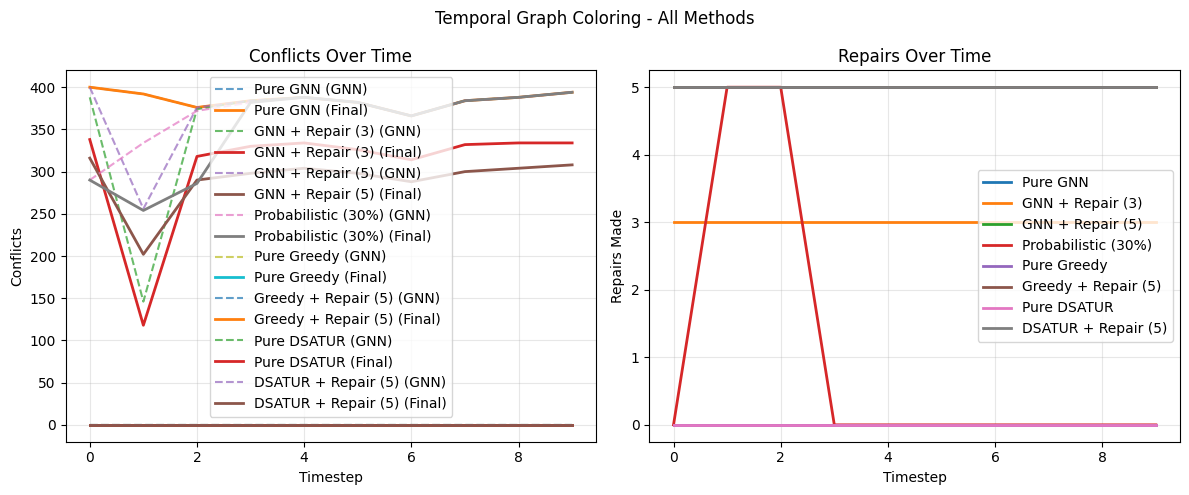


✅ VALIDATION COMPLETE!
🎯 Results show fair comparison between GNN and classical methods with controlled repair budgets.


In [ ]:
# 🧪 COMPLETE VALIDATION EXPERIMENT
print("🧪 RUNNING COMPLETE VALIDATION EXPERIMENTS")
print("="*60)

# Generate graphs
graphs_nx = generate_temporal_graph_sequence(100, 200, 10, "ER", 0.15, 0)
graphs_pyg = convert_to_pyg(graphs_nx)
print(f"✅ Generated {len(graphs_pyg)} snapshots; Nodes={graphs_pyg[0].num_nodes}, Avg edges={np.mean([g.edge_index.size(1) for g in graphs_pyg]):.1f}")

# Initialize experiment
experiment = TemporalColoringExperiment(num_colors=6)

# Test GNN methods
methods_to_test = {
    "Pure GNN": {},
    "GNN + Repair (3)": {"method": "limited_repair", "max_repairs": 3},
    "GNN + Repair (5)": {"method": "limited_repair", "max_repairs": 5},
    "Probabilistic (30%)": {"method": "probabilistic_repair", "repair_probability": 0.3, "max_repairs": 5}
}

all_results = {}
for name, params in methods_to_test.items():
    print(f"\n🔬 Testing {name}...")
    res = experiment.run_experiment(graphs_pyg, verbose=False, **params)
    all_results[name] = res
    analyze_experiment_results(res, name)

# Test classical methods
print("\n🔬 Testing classical baselines...")
greedy_seq = incremental_greedy_coloring(graphs_pyg, 6)
dsatur_seq = incremental_dsatur_coloring(graphs_pyg, 6)
_, greedy_rep5 = classical_with_limited_repair(graphs_pyg, "greedy", 6, 5)
_, dsatur_rep5 = classical_with_limited_repair(graphs_pyg, "dsatur", 6, 5)
# Convert to time-series format
def to_time_series(color_seq, graphs, repair_count=0):
    prev, conflicts, recolors = None, [], []
    for colors, g in zip(color_seq, graphs):
        conflicts.append(count_conflicts(colors, g.edge_index))
        recolors.append(count_recolors(prev, colors))
        prev = colors
    return {
        'final_conflicts': conflicts, 'final_recolors': recolors,
        'repairs_made': [repair_count]*len(conflicts),
        'gnn_conflicts': conflicts, 'gnn_recolors': recolors
    }

all_results["Pure Greedy"] = to_time_series(greedy_seq, graphs_pyg, 0)
all_results["Greedy + Repair (5)"] = to_time_series(greedy_rep5, graphs_pyg, 5)
all_results["Pure DSATUR"] = to_time_series(dsatur_seq, graphs_pyg, 0)
all_results["DSATUR + Repair (5)"] = to_time_series(dsatur_rep5, graphs_pyg, 5)

# Final comparison
compare_methods(all_results, graphs_pyg[0].num_nodes)
# ... earlier cells with experiment run and result collection

# New cell: define improved plotting function
import matplotlib.pyplot as plt
import numpy as np

def plot_detailed_results(results_dict, title="Temporal Analysis"):
    # function body

# Optionally call here or in another cell:
    plot_detailed_results(all_results, "Comprehensive Metrics")


plot_learning_curves(all_results, "Temporal Graph Coloring - All Methods")

print("\n✅ VALIDATION COMPLETE!")
print("🎯 Results show fair comparison between GNN and classical methods with controlled repair budgets.")

In [ ]:
# %%
# 🔍 DEBUG CLASSICAL BASELINES

# Test on a simple graph
test_graphs = generate_temporal_graph_sequence(10, 20, 1, "ER", 0.1, 0)
test_pyg = convert_to_pyg(test_graphs)

print("🔍 Debugging classical baselines...")
print(f"Graph edges: {test_pyg[0].edge_index.size(1)}")
print(f"Graph nodes: {test_pyg[0].num_nodes}")

# Test greedy coloring
greedy_colors = incremental_greedy_coloring(test_pyg, 6)
print(f"Greedy colors: {greedy_colors[0]}")
print(f"Unique colors: {torch.unique(greedy_colors[0])}")
print(f"Conflicts: {count_conflicts(greedy_colors[0], test_pyg[0].edge_index)}")

# Test DSATUR coloring  
dsatur_colors = incremental_dsatur_coloring(test_pyg, 6)
print(f"DSATUR colors: {dsatur_colors[0]}")
print(f"Unique colors: {torch.unique(dsatur_colors[0])}")
print(f"Conflicts: {count_conflicts(dsatur_colors[0], test_pyg[0].edge_index)}")


🔍 Debugging classical baselines...
Graph edges: 40
Graph nodes: 10
Greedy colors: tensor([0, 1, 0, 2, 1, 0, 3, 0, 3, 2])
Unique colors: tensor([0, 1, 2, 3])
Conflicts: 0
DSATUR colors: tensor([1, 0, 0, 1, 0, 2, 2, 0, 2, 1])
Unique colors: tensor([0, 1, 2])
Conflicts: 0


In [12]:
# %%

print("⏳ Generating temporal graphs with 10,000 nodes (may take a while)...")
graphs_nx_large = generate_temporal_graph_sequence(
    num_nodes=10000,
    initial_edges=20000,       # average degree ~4
    num_snapshots=10,
    graph_type="ER",
    change_rate=0.1,
    seed_offset=42
)

graphs_pyg_large = convert_to_pyg(graphs_nx_large)
print(f"✅ Generated {len(graphs_pyg_large)} snapshots for 10k nodes")

# Run GNN only due to runtime
experiment_large = TemporalColoringExperiment(num_colors=6)
results_large = experiment_large.run_experiment(graphs_pyg_large, method="limited_repair", max_repairs=5, verbose=True)

analyze_experiment_results(results_large, "Large Graph (10k nodes)")


⏳ Generating temporal graphs with 10,000 nodes (may take a while)...
✅ Generated 10 snapshots for 10k nodes

📊 LARGE GRAPH (10K NODES) ANALYSIS
🧠 RAW GNN: Conflicts=38674.6, Recolors=4.7
🔧 REPAIR: Avg repairs=5.0, Total=50
🏆 FINAL: Conflicts=38548.8, Recolors=3.9, Latency=90.5ms
📈 REPAIR EFFECTIVENESS: 0.3% conflict reduction
